In [2]:
"""TODO"""

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as c
import scipy.interpolate as interp
from tabulate import tabulate
import math
from scipy import optimize

data_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/MPMSAnneals'
data_suffix = 'dc.dat'
Tlim = (15,55)

# mounted = sorted(
            # [(int(x[0]), x[1]) for x in np.loadtxt('mounted.csv',
            #                                         delimiter=',',
            #                                         skiprows=1)],
            # key = lambda x: x[0] + x[1]/1000)

exclude_files = [
        'non-neutron',
        '2022_3_1',
        '2022_3_1_remeasure',
        '2022_3_1_remeasure_2',
        '2022_3_2',
        '2022_3_6',
        '2022_3_9',
        '2022_3_47',
        '2022_3_31',
        '2022_3_18',
        '2022_3_LP',
        '2022_3_x',
        # not mounted
        '2022_3_4',
        '2022_3_8',
        '2022_3_9',
        '2022_3_18',
        '2022_3_19',
        '2022_3_26',
        '2022_3_29',
        '2022_3_30',
        '2022_3_31',
        '2022_3_32',
        '2022_3_33',
        '2022_3_35',
        '2022_3_36',
        '2022_3_37',
        '2022_3_38',
        '2022_3_39',
        '2022_3_41',
        '2022_3_43',
        '2022_3_44',
        '2022_3_45',
        '2022_3_46',
        '2022_3_47',
        '2022_3_48',
        ]

mounted_files = [
        ]

# TODO: Clean this up
cmap=cm.viridis_r

def list_files(exclude=exclude_files):
    files = [f for f in os.listdir(data_prefix) if f.endswith(data_suffix)]
    for f in exclude_files:
        if not f.endswith(data_suffix):
            f = '{}.{}'.format(f, data_suffix)
        try:
            files.remove(f)
        except ValueError as e:
            continue
    return files

def read_fczfc(filename, returnTimestamp=True, skipRamp=True, forceSplit=True):
    """ Read data from a file generated by the MPMS as the result of a FC/ZFC scan.

    Parameters
    ----------
    filename : string
            The name of the file to be read. Should be suitable for use with open().
    returnTimestamp : boolean, optional
            If true, the return value includes the timestamp from the data file.
    skipRamp : boolean
            If true, doesn't include the constant-T field ramp in the ZC data.
        forceSplit : boolean
                        If true, returns 2-tuples with second component of None if no FC/ZFC split is found.

    Returns
    -------
    out : tuple
        If timestamp == True, the function returns:
            (
                (
                    (tempZ, tempF),         # Temperature (K)
                    (momentZ, momentF),     # Long moment (emu)
                    (fieldZ, fieldF),       # Applied Field (Oe)
                    (errZ, errF),           # Uncertainty in the long moment (emu)
                    (dTempZ, dTempF)        # Temperature range during scan (K)
                ),
                tStamp
            )
        In other words, a 2-tuple containing a 5-tuple and a float. The 5-tuple contains
        2-tuples of arrays of the interesting data, where the first element in each tuple
        is the ZFC array and the second element is the FC array. The float contains the
        Unix-epoch timestamp from the data file.

        If timestamp == False, just the 5-tuple of data is returned.
    """
    f = open(filename,'r')

    # Parse Header
    # Skip 1 more row that what is picked out by the loop below. (In order to skip the column headings)
    skip = 1

    # Loop over lines to find the beginning of the data section
    for line in f:
        skip += 1
        # Stop at the beginning of the Data section
        if line == "[Data]\n":
            break
        # Extract the measurement date and time
        else:
            if line[:12] == "FILEOPENTIME":
                splitLine = line.split(" ")
                timestamp = splitLine[1]

    # Parse data
    field, temp, moment, fit, err, dTemp = np.loadtxt(filename, delimiter=',', skiprows=skip, usecols=(2,3,4,7,8,25), unpack=True)

    f.close()

    # By default, skip the constant-T field ramp at the beginning
    if skipRamp:
        # Find the ramp and skip it
        delVals = 0
        for i, Field in enumerate(field[1:]):
            if (Field - field[i-1]) > 0.1:
                delVals +=1
        field  = field[delVals:]
        temp   = temp[delVals:]
        moment = moment[delVals:]
        fit    = fit[delVals:]
        err    = err[delVals:]
        dTemp  = dTemp[delVals:]

    # Split data into FC, ZFC sections
    dT = np.subtract(temp[1:],temp[:-1])
    dT = dT/np.mean(np.abs(dT))
    i = 0
    fczfcSplit = False
    while i < len(dT):
        if dT[i] < -10:
            fczfcSplit= True
            break
        i += 1

    if fczfcSplit or forceSplit:
        if fczfcSplit:
            fieldZ, fieldF   = np.array_split(field, [i+1])
            tempZ, tempF     = np.array_split(temp, [i+1])
            momentZ, momentF = np.array_split(moment, [i+1])
            fitZ, fitF       = np.array_split(fit, [i+1])
            errZ, errF       = np.array_split(err, [i+1])
            dTempZ, dTempF   = np.array_split(dTemp, [i+1])
        else:
            fieldZ  = field
            tempZ   = temp
            momentZ = moment
            fitZ    = fit
            errZ    = err
            dTempZ  = dTemp
            fieldF  = None
            tempF   = None
            momentF = None
            fitF    = None
            errF    = None
            dTempF  = None

        if returnTimestamp == True:
            return (((tempZ, tempF), (momentZ, momentF), (fieldZ, fieldF), (errZ, errF), (dTempZ, dTempF)), float(timestamp))
        else:
            return ((tempZ, tempF), (momentZ, momentF), (fieldZ, fieldF), (errZ, errF), (dTempZ, dTempF))
    else:
        if returnTimestamp == True:
            return ((temp, moment, field, err, dTemp), float(timestamp))
        else:
            return (temp, moment, field, err, dTemp)

def read_zfc(filename):
    if not  filename.startswith(data_prefix):
        filename = '{}/{}'.format(data_prefix, filename)
    if not filename.endswith(data_suffix):
        filename = '{}.{}'.format(filename, data_suffix)
    (T, _), (M, _), _, (eM, _), (eT, _) = read_fczfc(filename, returnTimestamp=False)
    return (T, M, eM, eT)

# TODO: Why would I want order != 1?
def calc_tc(T, M):
    "Warning: very naive calculation"
    dT, dM = calc_derivative(T, M)
    return np.sum(dT * dM)/np.sum(dM)

def map_filename_tc(files):
    # return {f:calc_tc(T, M) for f, (T, M, _, _) in [(f, read_zfc(f)) for f in files]}
    return {f:[calc_tc(T, M),calc_tc_width(T,M)] for f, (T, M, _, _) in [(f, read_zfc(f)) for f in files]}

def calc_outlier_delta(x, y, window):
    ind0 = list(range(window))
    ind1 = [-1 * i for i in ind0[::-1]]
    ind0[0] = None
    ind1[-1] = None
    y_avg = np.sum([y[i:j] for i, j in zip(ind0, ind1)], 0) / window
    hwin = int((window - 1)/2)
    delta = np.abs((y[hwin:-1*hwin] - y_avg) / (x[ind0[-1]:] - x[:ind1[0]]))
    return delta

def filter_outliers(x, y, window=3, threshold=0.1):
    """Window should be an odd integer."""

    delta = calc_outlier_delta(x, y, window)
    sd = np.mean(sorted(delta)[:-1])
    while True:
        mask = delta != np.max(delta)
        hwin = int((window - 1)/2)
        mask_pad = np.full(hwin, True)
        mask = np.concatenate([mask_pad, mask, mask_pad])
        old_x = x
        old_y = y
        x = x[mask]
        y = y[mask]
        delta = calc_outlier_delta(x, y, window)
        old_sd = sd
        sd = np.mean(sorted(delta)[:-1])
        if (old_sd - sd) / (sd + old_sd) <= threshold:
            break

    return old_x, old_y

# TODO: The width here is actually 2x what you would expect based on the name. Change something to make this clear.
def calc_derivative(T, M, eM=None, eT=None, width=1):
    """Calculate the derivative w.r.t. temperature.
    Errorbars not currently used.
    """
    poppers = []
    for i in range(1,len(T)):
        if T[i] == T[i-1]:
            poppers.append(i-1)
            M[i] = (M[i] + M[i-1])/2
    M = list(M)
    T = list(T)
    for popper in poppers[::-1]:
        M.pop(popper)
        T.pop(popper)
    M = np.array(M)
    T = np.array(T)

    
    dT = (T[width:] + T[:-1*width])/2
    dM = (M[width:] - M[:-1*width])/(T[width:] - T[:-1*width])

    return (dT[1:-1], dM[1:-1])

def sum_data(X, Y, weights=None, Npoints=100):
    """X and Y should be lists of arrays"""
    xmin = max([np.min(x) for x in X])
    xmax = min([np.max(x) for x in X])
    xpoints = np.linspace(xmin, xmax, Npoints)
    ypoints = np.zeros_like(xpoints)
    weights = weights or np.ones(len(X))
    for x, y, w in zip(X, Y, weights):
        interp_y = interp.interp1d(x, y)
        ypoints += w * interp_y(xpoints)
    return xpoints, ypoints

def makeplot_single(file):
    T, M, eM, eT = read_zfc(file)
    T, M = filter_outliers(T, M)
    dT, dM = calc_derivative(T, M, eM, eT)

    fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True)
    ax0.plot(dT, dM, '.-k', linewidth=0.5)
    #ax1.errorbar(T, M, eM, eT, fmt='.k')
    ax1.plot(T, M, '.k')

    fig.suptitle(file)
    ax1.set_xlabel("$T$ (K)")
    ax0.set_ylabel("$dM/dT$ (arb.)")
    ax1.set_ylabel("$M$ (arb.)")
    # ax0.set_ylim(0, 1.1*np.max(dM))
    # ax1.set_ylim(1.1*np.min(M), 0.01*np.abs(np.min(M)))
    # ax0.set_xlim(*Tlim)
    plt.show()

def makeplot_derivative_sum (files, divisions=2):
    """Make a plot of the temperature derivatives and their sum, as an approximation of the Tc distribution."""

    dT_set = []
    dM_set = []
    for f in files: 
        T, M, eM, eT = read_zfc(f)
        T, M = filter_outliers(T, M)
        dT, dM = calc_derivative(T, M, eM, eT)
        dT_set.append(dT)
        dM_set.append(dM)
        plt.plot(dT, dM, ':k')

    # Plot overall total
    Tsum, Msum = sum_data(dT_set, dM_set)
    plt.plot(Tsum, Msum, '-', label='Total', linewidth=4)

    # Plot subset totals
    ymax = 0
    for i, idx in enumerate(np.array_split(list(range(len(files))), divisions)):
        _Tsum, _Msum = sum_data(dT_set[idx[0]:idx[-1]+1], dM_set[idx[0]:idx[-1]+1])
        ymax = max(ymax, np.max(_Msum))
        plt.plot(_Tsum, _Msum, '-', label='Subset {}/{}'.format(i+1, divisions))

    plt.legend()
    plt.xlabel("$T$ (K)")
    plt.ylabel("$dM / dT$ (arb.)")
    plt.ylim(0, 1.1*ymax)
    plt.xlim(*Tlim)

def makeplot_proposal(files):

    T_set = []
    M_set = []
    dT_set = []
    dM_set = []
    for f in files:
        T, M, eM, eT = read_zfc(f)
        M *= 10
        eM *= 10
        T, M = filter_outliers(T, M)
        dT, dM = calc_derivative(T, M, eM, eT)
        T_set.append(T)
        M_set.append(M)
        dT_set.append(dT)
        dM_set.append(dM)

    fig, ax0 = plt.subplots(1,1)
    ax1 = ax0.inset_axes([40,-0.77,14,0.3], transform=ax0.transData)
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.tick_top()


    # Plot overall total
    Tsum, Msum = sum_data(T_set, M_set)
    ax0.plot(Tsum, Msum, '-', label='Total', linewidth=4)
    ymax = max(Msum)
    dTsum, dMsum = sum_data(dT_set, dM_set)
    ax1.plot(dTsum, dMsum, '-', label='Total', linewidth=4)
    dymax = max(dMsum)

    label = True
    for T, M, dT, dM in zip(T_set, M_set, dT_set, dM_set):
        if label:
            ax0.plot( T,  M, ':k', label='Individual crystals')
            ax1.plot(dT, dM, ':k', label='Individual crystals')
        else:
            ax0.plot( T,  M, ':k')
            ax1.plot(dT, dM, ':k')
        label = False

    ax0.set_xlim(Tlim)
    ax0.set_ylim((-0.8,0))
    ax0.set_xlabel("$T$ (K)")
    ax0.set_ylabel("$M(T)$ (arb.)")

    ax1.set_xlabel("$T$ (K)")
    ax1.set_ylabel("$dM / dT$ (arb.)")
    ax1.set_xticks([20, 30, 40])
    ax1.set_ylim(0, 1.1*dymax)
    ax1.set_xlim((15,50))

    ax0.legend(loc=(0.52,0.65))

def makeplot_lowest_n(files, ind_var=None):
    """Assumes files are sorted."""
    ind_var = ind_var or 'T'

    dT_set = []
    dM_set = []
    if ind_var == 'p':
        p_set = []
    for f in files:
        T, M, eM, eT = read_zfc(f)
        T, M = filter_outliers(T, M)
        dT, dM = calc_derivative(T, M, eM, eT)
        dT_set.append(dT)
        dM_set.append(dM)
        if ind_var == 'p':
            p_set.append(tc2doping(dT))

    imin = 1
    imax = len(dT_set)
    #fig, ax = plt.subplots(1,1)
    fig, ax = plt.subplots()
    for i in range(len(dT_set)+1,0,-1):
        if ind_var == 'p':
            im = ax.fill_between(*(sum_data(p_set[:i], dM_set[:i])), color=v2color(i,imin,imax))
        else:
            im = ax.fill_between(*(sum_data(dT_set[:i], dM_set[:i])), color=v2color(i,imin,imax))
    if ind_var == 'p':
        ax.set_xlabel("$p$")
    else:
        ax.set_xlabel("$T$ (K)")
    ax.set_ylabel("$dM / dT$ (arb.)")
    ax.set_title("Sharpest-$T_c$ subsets")
    ax.set_ylim(bottom=0)
    if ind_var == 'p':
        ax.set_xlim([tc2doping(t) for t in Tlim])
    else:
        ax.set_xlim(*Tlim)
    cb = ax.colorbar(cm.ScalarMappable(c.Normalize(imin,imax), cmap))
    #cb = plt.colorbar(cm.ScalarMappable(c.Normalize(imin,imax), cmap))
    cb.ax.set_ylabel("# of crystals")
    #cb.ax.set_xticks(TODO)

def v2color(v, vmin=0, vmax=1, cmap=cmap):
    x = (v-vmin)/(vmax-vmin)
    return cmap(x)

def get_mass(filename):
    if not filename.startswith(data_prefix):
        filename = '{}/{}'.format(data_prefix, filename)
    if not filename.endswith(data_suffix):
        filename = '{}.{}'.format(filename, data_suffix)
    with open(filename) as f:
        lines = f.readlines()
    for l in lines:
        if l.startswith('INFO, WEIGHT, '):
            return float(l.rsplit(', ', 1)[1]) 

def tc2doping(tc, datum='yamamoto2000', tc_factor=None, doping_factor=None):
    """Map Tc to doping level, based on published data

    WARNING: For now only the region near the underdoped edge of the SC dome is implemented.
    """
    # These were determined from offline fits of the full data sets to 6th order polynomials.
    if datum == 'yamamoto2000':
        p = {
            0:      -1573.942589112223,
            1:      85653.46705026535,
            2:   -1809615.0506439556,
            3:   19647139.47390952,
            4: -114974192.16912913,
            5:  344676089.4662196,
            6: -415662785.02835846,
            }
        tc_factor = tc_factor or 1
        doping_factor = doping_factor or 1
    elif datum == 'honma2008-yamamoto':
        p = {
            0:      -464.9074747079892,
            1:     20397.1150016484,
            2:   -308887.4967430896,
            3:   2308464.415825212,
            4:  -8535139.903885491,
            5:  14654512.839752782,
            6: -11437936.027919855,
            }
        tc_factor = tc_factor or 98
        doping_factor = doping_factor or 0.157

    interp_p = np.arange(0.040, 0.145, 0.001)
    interp_t = np.sum([p[i] * interp_p ** i for i in range(0, len(p))], axis=0)

    interp_f = interp.interp1d(interp_t, interp_p)  # TODO: Define more kwargs?
    return interp_f(tc)

# TODO: Implement?
def gen_map_dTc_p(data_source='TODO', underdoped=True):
    """Return an interpolation function that maps (Tc, error_Tc) to (doping, error_doping) based on the specified data source"""
    # TODO: implement underdoped/overdoped option. Currently always assume underdoped
    if data_source == 'honma2008-yamamoto':
        data = np.genfromtxt('honma-1c.csv', skip_header=2, delimiter=',',
                             usecols=(1,0))
    elif data_source == 'honma2008-wilson':
        data = np.genfromtxt('honma-1c.csv', skip_header=2, delimiter=',',
                             usecols=(3,2))
    elif data_source == 'yamamoto2000':
        data = [#Tc, p
                (0 , 0.046),
                (26, 0.050),
                (46, 0.057),
                (62, 0.069),
                (72, 0.090),
                (77, 0.103),
                (83, 0.110),
                (91, 0.119),
                (95, 0.127),
                (98, 0.157),
                (92, 0.180),
                (86, 0.190),
                (80, 0.208),
                ]
        data = np.array(data)
    # TODO: Trim under/overdoped?
    # TODO: Sort data
    # TODO: Smooth data
    #tc_interp = interp.interp1d(tc, p, kind='quadratic', bounds_error=False, fill_value=(TODO:min_p, TODO:max_p))
    dtc_interp = TODO
    return lambda tc, err: (tc_interp(tc), err*dtc_interp(tc))

def cleanup_name(filename):
    n = filename.removeprefix('2022_3_').removesuffix('.dc.dat').split('_')[0]
    return "2022_3_{}".format(n)

def calc_tc_width(dt, dm, Tc=None):
    Tc = Tc or np.sum(dt * dm)/np.sum(dm)
    return np.sum(np.abs(dt-Tc) * dm) / np.sum(dm)

def make_csv_line(filename, avg_tc, tc2p_func=None):
    tc2p_func = tc2p_func or tc2doping
    name = cleanup_name(filename)
    mass = get_mass(filename)
    t, m, eM, eT = read_zfc(filename)
    dt, dm = calc_derivative(t, m, eM, eT)
    Tc = calc_tc(t,m)
    DTc = Tc - avg_tc
    dTc = calc_tc_width(t, m)
    _dp = tc2p_func([Tc+dTc, Tc-dTc])
    dp = np.abs(_dp[0] - _dp[1])
    print("{},{},{},{},{},{}".format(name, mass, Tc, DTc, dTc, dp))

def get_anneal_histogram(anneal):
    # print(os.listdir('{}/{}'.format(data_prefix,anneal)))
    files = os.listdir('{}/{}'.format(data_prefix,anneal))
    for i in range(len(files)):
        files[i] = '{}/{}/{}'.format(data_prefix,anneal,files[i])
    files = [x for x in files if x.endswith('.dat')]
    anneal_dict = map_filename_tc(files)
    tcs =np.transpose(list(anneal_dict.values()))
    if len(tcs)>0:
        print(tcs)
        fig = plt.figure(constrained_layout = True)
        ax = fig.add_subplot(2, 1, 1)
        bx = fig.add_subplot(2, 1, 2)
        ax.hist(tcs[0])
        ax.set_xlabel('Tc (K)')
        ax.set_ylabel('Counts')
        ax.set_title(anneal)
        bx.hist(tcs[1])
        bx.set_xlabel('Tc Width (K)')
        bx.set_ylabel('Counts')
        bx.set_title(anneal)
        plt.show()
    else:
        print('No Tcs for '+anneal)

def get_anneal_tcinfo(anneal):
    
    files = os.listdir('{}/{}'.format(data_prefix,anneal))
    files = ['{}/{}/{}'.format(data_prefix,anneal,x) for x in files if x.endswith('.dat')]
    if len(files)>0:
        anneal_dict = map_filename_tc(files)
        for anneal in anneal_dict:
            if anneal_dict[anneal][0]<0 or anneal_dict[anneal][0] >82:
                makeplot_single(anneal)
                print(anneal_dict[anneal])
        tcs = [ x for x in list(anneal_dict.values()) if not(math.isnan(x[0]))]
        broken = [x for x in anneal_dict if math.isnan(anneal_dict[x][0])]
        if len(broken)>0:
            # print(broken)
            for broke in broken:
                try:
                    makeplot_single(broke)
                except:
                    print(broke,'\nis super broken')
        tcs = np.transpose(tcs)
        ret_str = anneal[len(data_prefix)+1:]
        i = 0
        for c in ret_str:
            if c =='/':
                break
            i+=1

        return [ret_str[:i],np.average(tcs[0]),np.average(tcs[1]),len(anneal_dict)]
    else:
        return None

def rev_nones(data):
    i = 0
    bads = []
    for d in data:
        # print(d)
        if type(d) == type(None):
            bads.append(i)
        i+= 1
    for bad in bads[::-1]:
        data.pop(bad)
    return data

def get_ACMS_data(filename):
    f = open(filename,'r')
    # Parse Header
    # Skip 1 more row that what is picked out by the loop below. (In order to skip the column headings)
    skip = 1

    # Loop over lines to find the beginning of the data section
    for line in f:
        skip += 1
        # Stop at the beginning of the Data section
        if line == "[Data]\n":
            break
    # Comment,Time Stamp (sec),Temperature (K),Magnetic Field (Oe),Frequency (Hz),Amplitude (Oe),M-DC (emu),M-Std.Dev. (emu),M' (emu),M'' (emu),Moment (emu),Phase (deg),Calcoil' (emu),Calcoil'' (emu),Calcoil (emu),CC Phase (deg),Count,Gain,Measure Type,Elapsed (sec),Sample Center (cm)
    # Parse data
    # temp, field, freq, amp, M_DC, M1, M2, moment, phase, sample_center= 
    return np.loadtxt(filename, delimiter=',', skiprows=skip, usecols=(2,3,4,5,8,9,10,11,20), unpack=True)

In [68]:

if __name__ == '__main__':
    tc = map_filename_tc(list_files())
    avg_tc = np.mean([v for v in tc.values()])  # TODO: Normalize by mass or something
    diff_tc = {k: np.abs(v - avg_tc) for k, v in tc.items()}
    dtc_sorted_files = [f for f, t in sorted(diff_tc.items(), key=lambda it: it[1])]

    if sys.argv[1:] == []:
        makeplot_derivative_sum(dtc_sorted_files, 3)
        plt.show()
        makeplot_lowest_n(dtc_sorted_files)
        plt.show()
        makeplot_lowest_n(dtc_sorted_files, ind_var='p')
        plt.show()
        for f, t in sorted(diff_tc.items(), key=lambda it: it[1]):
            print("{} : ΔTc = {}".format(f.removesuffix('.dc.dat'), t))
    if 'sum' in sys.argv[1:]:
        makeplot_derivative_sum(dtc_sorted_files, 3)
        plt.show()
    if 'lowest' in sys.argv[1:]:
        makeplot_lowest_n(dtc_sorted_files)
        plt.show()
    if 'single' in sys.argv[1:]:
        for f in dtc_sorted_files:
            makeplot_single(f)
            plt.show()
    if 'proposal-fig' in sys.argv[1:]:
        makeplot_proposal(dtc_sorted_files)
        plt.show()
    if 'summary' in sys.argv[1:]:
        mass = 0
        for f in mounted_files:
            mass += get_mass(f)
        print("Total mass: {} mg".format(mass))
        dT_set = []
        dM_set = []
        for f in mounted_files:
            T, M, eM, eT = read_zfc(f)
            T, M = filter_outliers(T, M)
            dT, dM = calc_derivative(T, M, eM, eT)
            dT_set.append(dT)
            dM_set.append(dM)
        Tsum, Msum = sum_data(dT_set, dM_set)
        avg = np.average(Tsum, weights=Msum)
        std = np.sqrt(
                np.average(
                    np.square(Tsum - avg),
                    weights = Msum)
                )
        print("Tc = {} +/- {} K".format(avg, std))
        makeplot_derivative_sum(mounted_files, divisions=1)
        plt.show()
    if 'csv' in sys.argv[1:]:
        # Print csv to file, make tiny plots for cells?
        for f in list_files():
            make_csv_line(f, avg_tc)
    if 'final-summary' in sys.argv[1:]:
        makeplot_final_fczfc()
        makeplot_final_dist()
        #makeplot_final_mosaic()


c:\Users\blake\Documents\VSCode\Python\.venv\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\blake\Documents\VSCode\Python\.venv\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[-8.47342017e-02  8.12815655e+02]
[-1.87493863e-01  6.33986327e+02]
[-1.44270433e-01  6.83667070e+02]


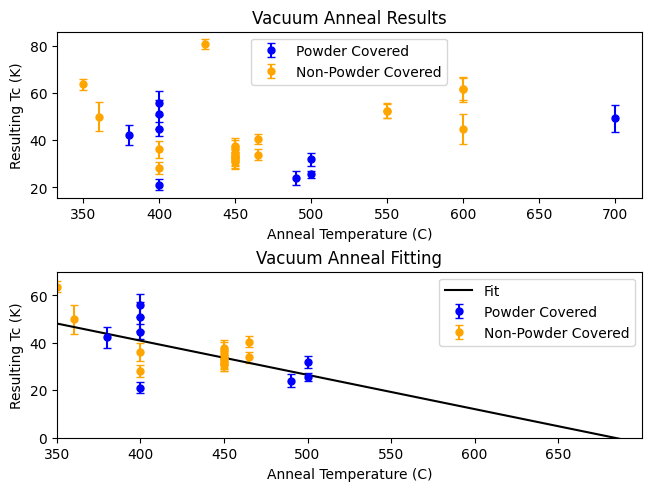

In [128]:
folders_path = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/MPMSAnneals'
anneal_log_path = 'C:/Users/blake/Documents/VSCode/Python/Greven/Hg1201 Anneals.csv'

# anneal_list = os.listdir(folders_path)

log_data = np.loadtxt(anneal_log_path, delimiter=',', dtype = str,usecols=np.arange(0,18))#use cols takes out the notes column
headers = log_data[0]
full_data = log_data[1:]
vacuum_anneals, vac_Ts = np.transpose([(row[0],row[7]) for row in full_data if row[9] == 'Vacuum' and row[1] == 'Hg1201'])

powder,pow_Ts = np.transpose([(row[0],row[7]) for row in full_data if row[9] == 'Vacuum' and row[1] == 'Hg1201' and row[8] == 'Yes'])
no_pow,nopow_Ts = np.transpose([(row[0],row[7]) for row in full_data if row[9] == 'Vacuum' and row[1] == 'Hg1201' and row[8] == 'No'])

#get data
tcs = {anneal:get_anneal_tcinfo(anneal) for anneal in vacuum_anneals if anneal in os.listdir(folders_path)}
data = [get_anneal_tcinfo(anneal) for anneal in vacuum_anneals if anneal in os.listdir(folders_path)]



# remove nones
data = rev_nones(data)
# pow_data = rev_nones(pow_data)
# no_pow = rev_nones(no_pow)



# write to csv
# csv_path = 'C:/Users/blake/Documents/VSCode/Python/Greven/AnnealTcs.csv'
# for row in full_data:
#     for anneal in data:
#         if row[0] == anneal[0]:
#             row[10] = anneal[1]
#             row[11] = anneal[2]
#             row[12] = anneal[3]
# np.savetxt(csv_path,full_data,fmt='%s',delimiter=',')

# for tc in tcs:
#     print(tc,tcs[tc])

# for anneal in [x for x in vacuum_anneals if x in os.listdir(folders_path)]:
#     # print(anneal)
#     get_anneal_histogram(anneal)

pow_data = []
no_pow_data = []
for anneal in powder:
    if anneal in os.listdir(folders_path):
        pow_data.append(get_anneal_tcinfo(anneal))
    else:
        pow_data.append(None)
for anneal in no_pow:
    if anneal in os.listdir(folders_path):
        no_pow_data.append(get_anneal_tcinfo(anneal))
    else:
        no_pow_data.append(None)

# i1 = np.logical_not(pow_data == None)
# i2 = np.logical_not(no_pow_data == None)
# print(pow_Ts[i1],pow_data[i1])
pow_Ts = list(pow_Ts)
nopow_Ts = list(nopow_Ts)
i = 0
bads = []
for d in pow_data:
    if type(d) == type(None):
        bads.append(i)
    i+= 1
for bad in bads[::-1]:
    pow_data.pop(bad)
    pow_Ts.pop(bad)
i = 0
bads = []
for d in no_pow_data:
    if type(d) == type(None):
        bads.append(i)
    i+= 1
for bad in bads[::-1]:
    no_pow_data.pop(bad)
    nopow_Ts.pop(bad)

_,pow_tcs,pow_err,_ = np.transpose(pow_data)
pow_tcs = [float(x) for x in pow_tcs]
pow_err = [float(x)/2 for x in pow_err]
pow_Ts = [float(x) for x in pow_Ts]
_,nopow_tcs,nopow_err,_ = np.transpose(no_pow_data)
nopow_tcs = [float(x) for x in nopow_tcs]
nopow_err = [float(x)/2 for x in nopow_err]
nopow_Ts = [float(x) for x in nopow_Ts]



fig = plt.figure(constrained_layout = True)
ax = fig.add_subplot(2, 1, 1)
cx = fig.add_subplot(2, 1, 2)
ax.errorbar(pow_Ts,pow_tcs,pow_err,ls='none',c = 'blue',marker='o', capsize=3,ms = 5)
ax.errorbar(nopow_Ts,nopow_tcs,nopow_err,ls='none',c = 'orange',marker='o', capsize=3,ms = 5)
ax.set_xlabel('Anneal Temperature (C)')
ax.set_ylabel('Resulting Tc (K)')
ax.set_title('Vacuum Anneal Results')
ax.legend(['Powder Covered','Non-Powder Covered'])
cx.set_xlabel('Anneal Temperature (C)')
cx.set_ylabel('Resulting Tc (K)')
cx.set_title('Vacuum Anneal Fitting')

i = 0
bads = []
for d in pow_data:
    if float(pow_Ts[i])>650:
        bads.append(i)
    i+= 1
for bad in bads[::-1]:
    pow_tcs.pop(bad)
    pow_err.pop(bad)
    pow_Ts.pop(bad)
i = 0
bads = []
for d in no_pow_data:
    if float(nopow_Ts[i])>500 or float(no_pow_data[i][1])> 80:
        bads.append(i)
    i+= 1
for bad in bads[::-1]:
    nopow_tcs.pop(bad)
    nopow_err.pop(bad)
    nopow_Ts.pop(bad)

def x_line(x, m,x0):
    return m*(x-x0)
#pow fit
guesses1 = [-.25,600]
pbounds1 = np.array([[-10,400],[0,1000]]) # [[Lower bounds],[upper bounds]]
bestfit = optimize.curve_fit(x_line,pow_Ts,pow_tcs,guesses1, sigma= pow_err, bounds=pbounds1)
bestpars1 = bestfit[0]
print(bestpars1)
#no pow fit
guesses2 = [-.25,600]
pbounds2 = np.array([[-10,400],[0,1200]]) # [[Lower bounds],[upper bounds]]
bestfit = optimize.curve_fit(x_line,nopow_Ts,nopow_tcs,guesses2, sigma= nopow_err, bounds=pbounds2)
bestpars2 = bestfit[0]
print(bestpars2)
#total fit
guesses3 = [-.25,600]
pbounds3 = np.array([[-10,400],[0,1200]]) # [[Lower bounds],[upper bounds]]
bestfit = optimize.curve_fit(x_line,pow_Ts+nopow_Ts,pow_tcs+nopow_tcs,guesses3, sigma= pow_err+nopow_err, bounds=pbounds3)
bestpars3 = bestfit[0]
print(bestpars3)

cx.errorbar(pow_Ts,pow_tcs,pow_err,ls='none',c = 'blue',marker='o', capsize=3,ms = 5)
cx.errorbar(nopow_Ts,nopow_tcs,nopow_err,ls='none',c = 'orange',marker='o', capsize=3,ms = 5)

# xmax = 850
xmax = 700
cx.set_ylim([0,70])
cx.set_xlim([350,xmax])
cx.set_xticks(np.arange(350,xmax,50))
# cx.plot(np.array([350,813]),bestpars1[0]*(np.array([350,813])-bestpars1[1]),c='green')
# cx.plot(np.array([350,813]),bestpars2[0]*(np.array([350,813])-bestpars2[1]),c='red')
cx.plot(np.array([350,xmax]),bestpars3[0]*(np.array([350,xmax])-bestpars3[1]),c='black')
# _ =cx.legend(['Powder Only Fit','Non-Powder Only Fit','Total Fit','Powder Covered','Non-Powder Covered'])
_ =cx.legend(['Fit','Powder Covered','Non-Powder Covered'])

[10.0, 26.8266542404473, 71.9687791239515, 193.069897483691, 517.949673811743, 1389.5, 3727.60018639329, 10000.0]


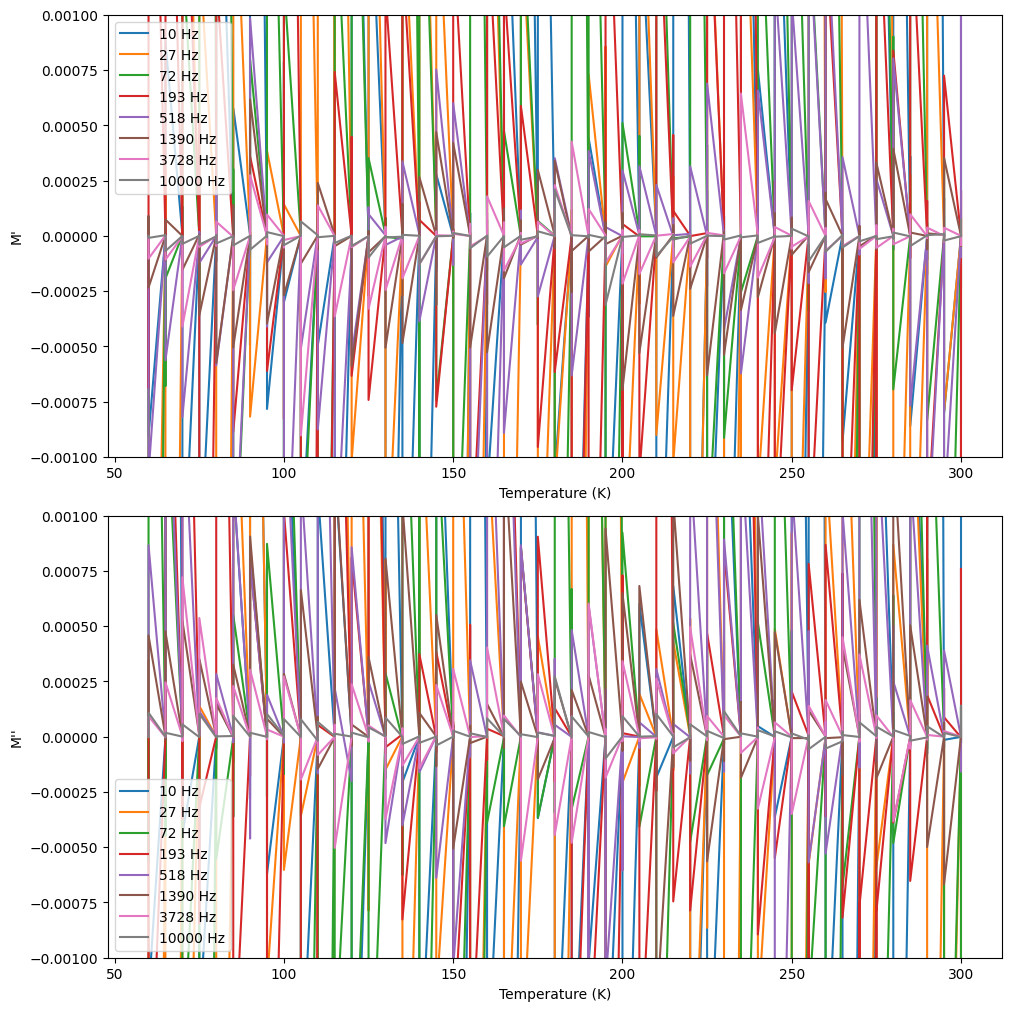

In [8]:
path_prefix = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/'
path_suffix = '.dat'
# filename = 'SteelTube_00001'
filename = '2023_4_1b_2'

ppms_path = path_prefix + filename + path_suffix

temp, field, freq, amp, M1, M2, moment, phase, sample_center= get_ACMS_data(ppms_path)
freqs = []
for fre in freq:
    if not(fre in freqs):
        freqs.append(fre) 

print(freqs)
temps = []
M1s = []
M2s = []
for fre in freqs:
    inds = np.logical_not(freq !=fre)
    temps.append(temp[inds])
    M1s.append(M1[inds])
    M2s.append(M2[inds])
fig = plt.figure(constrained_layout = True, figsize=(10,10))
ax = fig.add_subplot(2, 1, 1)
bx = fig.add_subplot(2, 1, 2)
leg = []
for i, fre in enumerate(freqs):
    leg.append(str(round(fre))+' Hz')
    ax.plot(temps[i],M1s[i])
    bx.plot(temps[i],M2s[i])

ax.legend(leg)
bx.legend(leg)
ax.set_xlabel('Temperature (K)')
bx.set_xlabel('Temperature (K)')
ax.set_ylabel("M\'")
_ = bx.set_ylabel("M\'\'")
y0 = 0.001
ax.set_ylim(-y0,y0)
bx.set_ylim(-y0,y0)
plt.show()